<a href="https://colab.research.google.com/github/jajapuramshivasai/projects_24/blob/main/grovers_factoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PRIME FACTORIZATION USING GROVER'S SEARCH ALGORITHM##

In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 47.0 MB/s eta 0:00:00


In [2]:
import matplotlib.pyplot as plt
import pennylane as qml
import numpy as np

In [3]:
#classical processing functiions


def get_bits(num):
  if num == 0:
    return 1
  count = 0
  while num > 0:
    num //= 2
    count += 1
  return count

def extract_factors(lst):
    list(lst).reverse()
    idx1, idx2 = 0 , 0
    if lst[0] > lst[1]:
        idx1, idx2 = 0, 1
    else:
        idx1, idx2 = 1, 0
    for i in range(2, len(lst)):
        if lst[i] > lst[idx1]:
            idx2 = idx1
            idx1 = i
        elif lst[i] > lst[idx2]:
            idx2 = i

    return idx1, idx2

def dec_to_bin(n):
  if n == 0:
    return "0"
  binary = ""
  while n > 0:
    remainder = n % 2
    binary = str(remainder) + binary
    n //= 2
  return binary


In [4]:
#quantum  sub-circuits


def equal_superposition(wires):
    for wire in wires:
        qml.Hadamard(wires=wire)

def diffuser(wires):

  for wire in wires:
    qml.Hadamard(wires=wire)
    qml.PauliX(wires=wire)

  # qml.MultiRZ(2*np.pi,wires)
  qml.Hadamard(wires[0])
  qml.MultiControlledX(wires[1::],wires[0])
  qml.Hadamard(wires[0])

  for wire in wires:
    qml.PauliX(wires=wire)
    qml.Hadamard(wires=wire)

def add_k_fourier(k, wires):
    for j in range(len(wires)):
        qml.RZ(k * np.pi / (2**j), wires=wires[j])

def multiplication(wires_m, wires_k, wires_solution):
    # prepare sol-qubits to counting
    qml.QFT(wires=wires_solution)

    # add m to the counter
    for i in range(len(wires_k)):
        for j in range(len(wires_m)):
            coeff = 2 ** (len(wires_m) + len(wires_k) - i - j - 2)
            qml.ctrl(add_k_fourier, control=[wires_k[i], wires_m[j]])(coeff, wires_solution) #problem

    # return to computational basis
    qml.adjoint(qml.QFT)(wires=wires_solution)


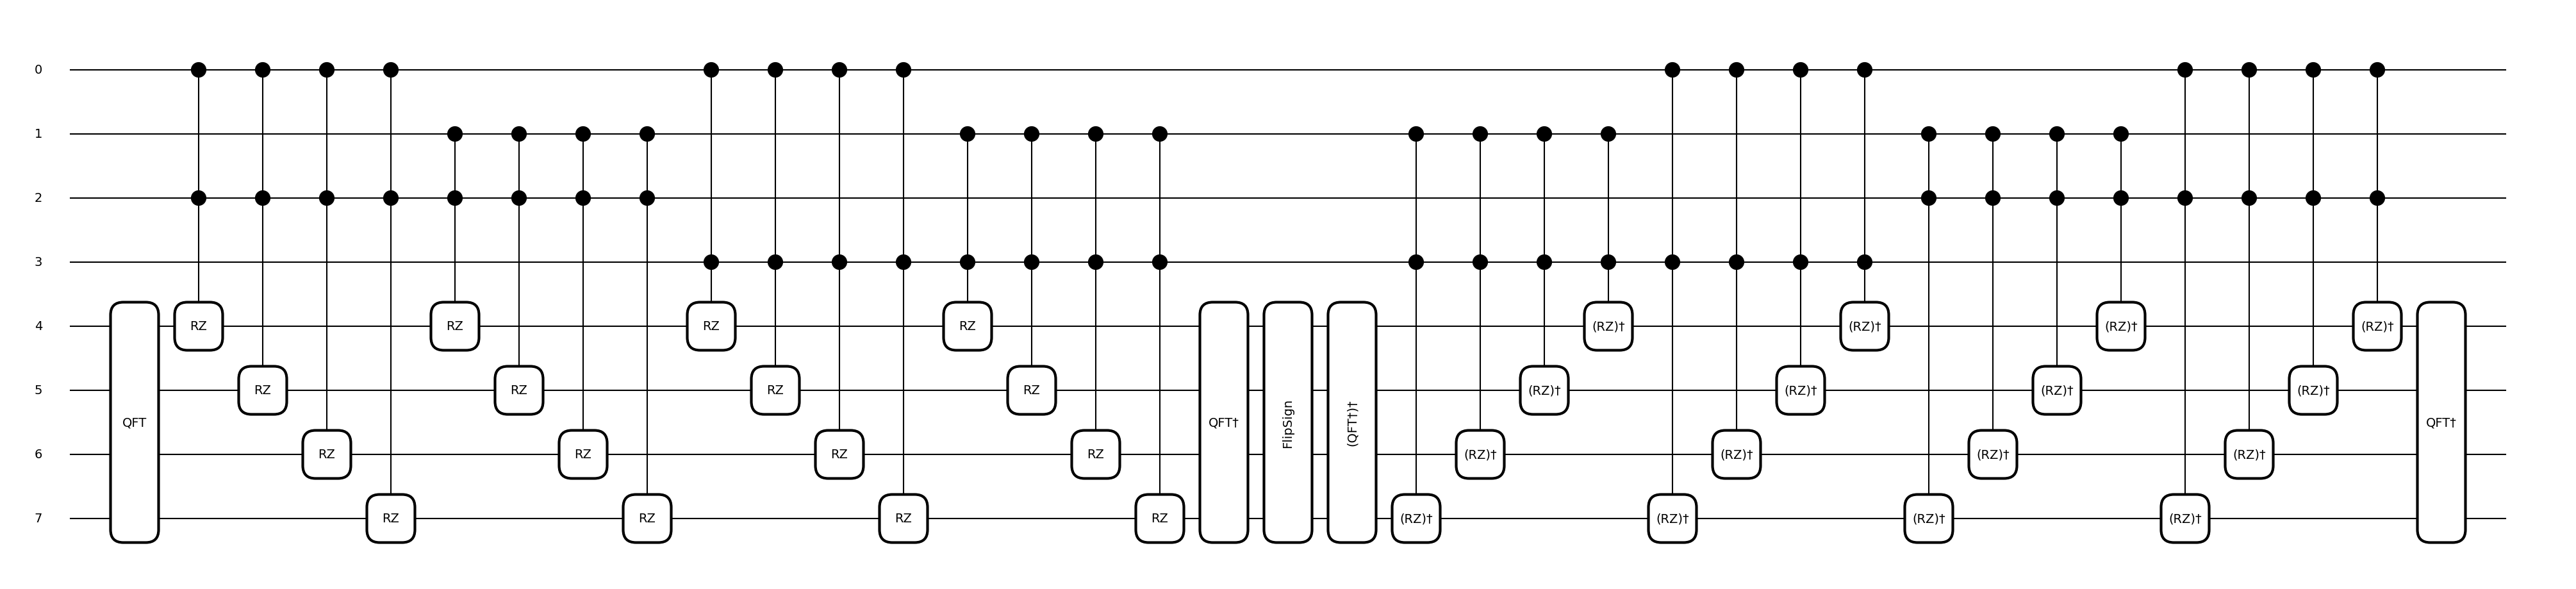

In [5]:
def oracle(z,x_wires,y_wires,z_wires):


  multiplication(wires_m = x_wires, wires_k = y_wires, wires_solution = z_wires)

  qml.FlipSign(z, wires=z_wires)

  qml.adjoint(multiplication)(wires_m = x_wires, wires_k = y_wires, wires_solution = z_wires)



qml.draw_mpl(oracle, show_all_wires=True)(6,[0,1],[2,3],[4,5,6,7])
plt.show()


/usr/local/lib/python3.10/dist-packages/pennylane/ops/op_math/controlled_ops.py:1051: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


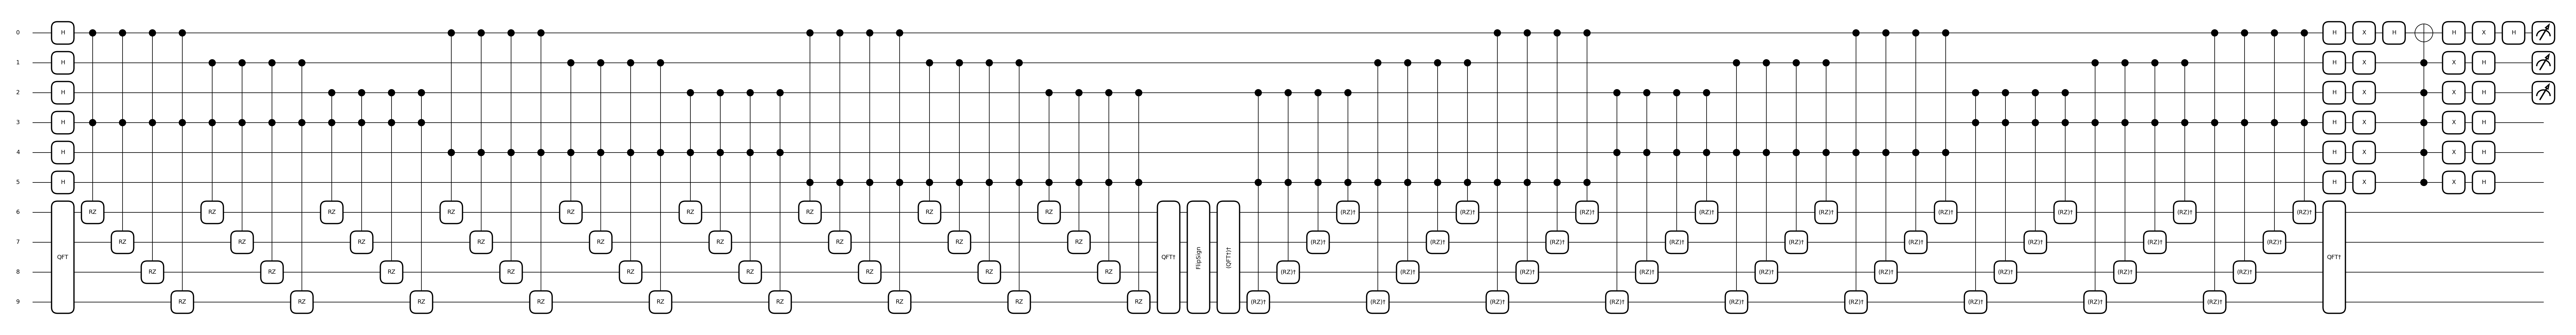

In [6]:

dev = qml.device("default.qubit")

@qml.qnode(dev)
def quantum_circuit(Z,x_wires,y_wires,z_wires,iterations):


  equal_superposition(x_wires)
  equal_superposition(y_wires)


  # state_prep(Z,z_wires)


  for i in range(iterations):

    #repeat phase oracle and diffuser repeatedly

    oracle(Z,x_wires,y_wires,z_wires)
    diffuser(x_wires+y_wires)


  # output  = extract_factors(out,x_wires,y_wires)
  return qml.probs(wires = x_wires) #result_x #output



qml.draw_mpl(quantum_circuit,show_all_wires= True)(Z = 15,x_wires = [0,1,2],y_wires = [3,4,5],z_wires = [6,7,8,9],iterations = 1)
plt.show()

/usr/local/lib/python3.10/dist-packages/pennylane/ops/op_math/controlled_ops.py:1051: UserWarning: The control_wires keyword for MultiControlledX is deprecated, and will be removed soon. Use wires = (*control_wires, target_wire) instead.
  warnings.warn(


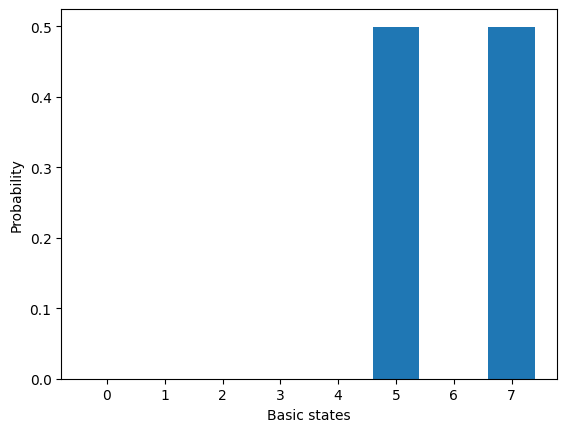

In [7]:
n = 35 # number we want to factor

wires_m = [0, 1, 2]                 # qubits needed to encode m
wires_k = [3, 4, 5]                 # qubits needed to encode k
wires_solution = [6, 7, 8, 9, 10,11]   # qubits needed to encode the solution


plt.bar(range(2 ** len(wires_m)), quantum_circuit(Z = n,x_wires= wires_m,y_wires= wires_k, z_wires = wires_solution,iterations=4))
plt.xlabel("Basic states")
plt.ylabel("Probability")
plt.show()


In [8]:
def factor_biprime(N , delta = 0,output = 'factors'):


  #additional logic

  if N%2 == 0 or N%3 == 0:
    return 'trivial factors'
  elif N == 1:
    return 'trivial factors'

  #preprocessing



  n_z = get_bits(N)
  n_x = n_z//2
  n_y = n_z//2

  iterations = int(np.floor((np.pi/4)*2**(n_z/2))) + delta
  #assigining integer registers onto quantum computer


  """
  circuit integer register layout
  |--------Z----------|   |----------x-----------|   |----------------y-----------------|
  [0,1,2, .... (n_z)-1]   [(n_z),...(n_z)+(n_x)-1]   [(n_z)+(n_x),...(n_z)+(n_x)+(n_y)-1]
  """


  z_wires = list(range(n_z))
  x_wires = list(range(n_z,n_z+n_x))
  y_wires = list(range(n_z+n_x,n_z+n_x+n_y))


  #quantum processing on qnode

  device = qml.device("default.qubit" , wires = z_wires+x_wires+y_wires)

  node = qml.QNode(quantum_circuit,device)

  probabilities = node(Z = N , x_wires = x_wires , y_wires = y_wires ,z_wires = z_wires ,iterations = iterations)

  # print(np.argmax(probabilities)

  result = extract_factors(probabilities)


  if output == 'factors':
    return result

  elif output == 'probabilities':
    return probabilities

  elif output == 'all parameters':
    return str(f"n_z: {n_z},\nn_x: {n_x},\nn_y: {n_y},\niterations: {iterations},\nprobabilities: {[f'{p:.2f}' for p in probabilities]}\n")


testing factor_biprime function

n_z: 6,
n_x: 3,
n_y: 3,
iterations: 4,
probabilities: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.50', '0.00', '0.50']



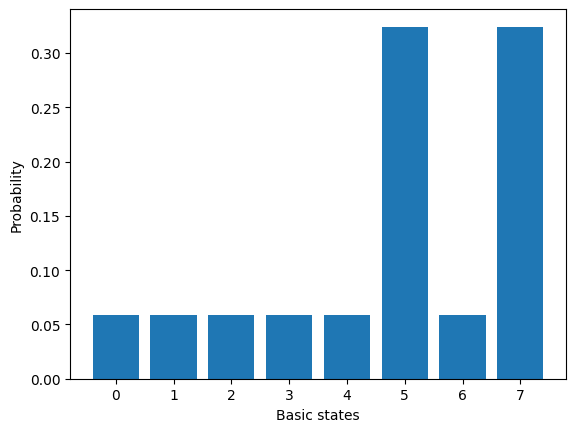

In [15]:

print(factor_biprime(35,-2,output = 'all parameters'))


plt.bar(range(2 ** 3),factor_biprime(35,output = 'probabilities') )
plt.xlabel("Basic states")
plt.ylabel("Probability")
plt.show()